In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add, Input
from tensorflow.keras.callbacks import EarlyStopping
from prophet import Prophet

In [22]:
# 1. Load the dataset
data = pd.read_csv('./data/BrentOilPrices.csv')

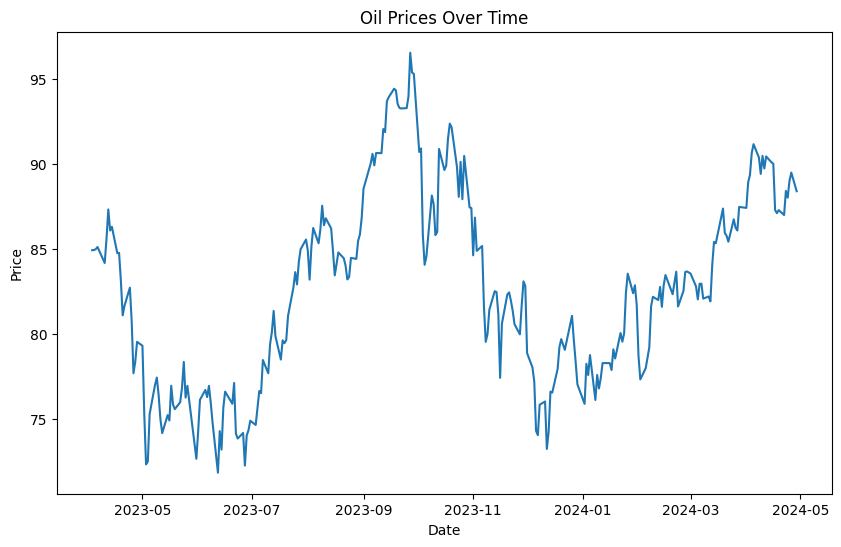

In [23]:
# 2. Preprocess the data
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Price'])
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.savefig('outputs/Oil Prices Over 2023 04 to 2024 04.png')
plt.show()

In [4]:
# Normalize the price data for LSTM and Transformer
scaler = MinMaxScaler(feature_range=(0, 1))
data['Price'] = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

# Split data into training and test sets
split = int(0.8 * len(data))
train, test = data[:split], data[split:]

# Prepare sequences for LSTM and Transformer
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 60
X, y = create_sequences(data['Price'].values, seq_length)

# Split into train and test sets
X_train, X_test = X[:split-seq_length], X[split-seq_length:]
y_train, y_test = y[:split-seq_length], y[split-seq_length:]

# Reshape X for LSTM and Transformer [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [5]:
# 3. Train LSTM Model
def build_lstm_model(seq_length):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_model = build_lstm_model(seq_length)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
lstm_pred = lstm_model.predict(X_test)

Epoch 1/100
5/5 [==============================] - 4s 232ms/step - loss: 0.1403 - val_loss: 0.0280
Epoch 2/100
5/5 [==============================] - 0s 39ms/step - loss: 0.0468 - val_loss: 0.0048
Epoch 3/100
5/5 [==============================] - 0s 44ms/step - loss: 0.0313 - val_loss: 0.0259
Epoch 4/100
5/5 [==============================] - 0s 36ms/step - loss: 0.0308 - val_loss: 0.0216
Epoch 5/100
5/5 [==============================] - 0s 38ms/step - loss: 0.0218 - val_loss: 0.0065
Epoch 6/100
5/5 [==============================] - 0s 38ms/step - loss: 0.0233 - val_loss: 0.0043
Epoch 7/100
5/5 [==============================] - 0s 40ms/step - loss: 0.0230 - val_loss: 0.0062
Epoch 8/100
5/5 [==============================] - 0s 40ms/step - loss: 0.0204 - val_loss: 0.0105
Epoch 9/100
5/5 [==============================] - 0s 42ms/step - loss: 0.0207 - val_loss: 0.0078
Epoch 10/100
5/5 [==============================] - 0s 37ms/step - loss: 0.0180 - val_loss: 0.0043
Epoch 11/100
5/5 [

In [6]:
# 4. Train Transformer Model
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(seq_length, d_model, num_heads, ff_dim, num_transformer_blocks, rate=0.1):
    inputs = Input(shape=(seq_length, 1))
    x = Dense(d_model)(inputs)
    for _ in range(num_transformer_blocks):
        x = TransformerBlock(d_model, num_heads, ff_dim, rate)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(rate)(x)
    outputs = Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [7]:
d_model = 64
num_heads = 4
ff_dim = 64
num_transformer_blocks = 2
rate = 0.1

transformer_model = build_transformer_model(seq_length, d_model, num_heads, ff_dim, num_transformer_blocks, rate)
transformer_model.compile(optimizer='adam', loss='mean_squared_error')
transformer_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
transformer_pred = transformer_model.predict(X_test)

Epoch 1/100
5/5 [==============================] - 4s 152ms/step - loss: 2.6451 - val_loss: 1.7476
Epoch 2/100
5/5 [==============================] - 0s 75ms/step - loss: 1.0165 - val_loss: 0.0314
Epoch 3/100
5/5 [==============================] - 0s 81ms/step - loss: 0.5533 - val_loss: 0.2879
Epoch 4/100
5/5 [==============================] - 0s 77ms/step - loss: 0.3556 - val_loss: 0.0902
Epoch 5/100
5/5 [==============================] - 0s 93ms/step - loss: 0.3250 - val_loss: 0.1586
Epoch 6/100
5/5 [==============================] - 0s 79ms/step - loss: 0.2090 - val_loss: 0.0259
Epoch 7/100
5/5 [==============================] - 0s 74ms/step - loss: 0.2457 - val_loss: 0.0225
Epoch 8/100
5/5 [==============================] - 0s 70ms/step - loss: 0.2443 - val_loss: 0.0577
Epoch 9/100
5/5 [==============================] - 0s 83ms/step - loss: 0.2537 - val_loss: 0.0481
Epoch 10/100
5/5 [==============================] - 0s 76ms/step - loss: 0.2345 - val_loss: 0.0208
Epoch 11/100
5/5 [

In [8]:
# 5. Train Prophet Model
# Prepare data for Prophet
prophet_data = data.reset_index().rename(columns={'Date': 'ds', 'Price': 'y'})
prophet_data

,ds,y
0,2023-04-03,0.529745
1,2023-04-04,0.530150
2,2023-04-05,0.532173
3,2023-04-06,0.537434
4,2023-04-10,0.499393
...,...,...
266,2024-04-23,0.670983
267,2024-04-24,0.654795
268,2024-04-25,0.694860
269,2024-04-26,0.714690


In [9]:
# Split the data for Prophet
train_prophet = prophet_data.iloc[:split].copy()
test_prophet = prophet_data.iloc[split:].copy()
train_prophet

,ds,y
0,2023-04-03,0.529745
1,2023-04-04,0.530150
2,2023-04-05,0.532173
3,2023-04-06,0.537434
4,2023-04-10,0.499393
...,...,...
211,2024-02-02,0.222177
212,2024-02-05,0.248887
213,2024-02-06,0.273169
214,2024-02-07,0.298260


In [10]:
# Train the Prophet model
prophet_model = Prophet()
prophet_model.fit(train_prophet)

22:27:46 - cmdstanpy - INFO - Chain [1] start processing
22:27:46 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# Make future predictions
future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='D')
future

,ds
0,2023-04-03
1,2023-04-04
2,2023-04-05
3,2023-04-06
4,2023-04-10
...,...
266,2024-03-30
267,2024-03-31
268,2024-04-01
269,2024-04-02


In [12]:
future.loc[0]

ds   2023-04-03
Name: 0, dtype: datetime64[ns]

In [13]:
forecast = prophet_model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-04-03,0.285754,0.034858,0.501995,0.285754,0.285754,-0.033122,-0.033122,-0.033122,-0.033122,-0.033122,-0.033122,0.0,0.0,0.0,0.252632
1,2023-04-04,0.287382,0.008462,0.472517,0.287382,0.287382,-0.041992,-0.041992,-0.041992,-0.041992,-0.041992,-0.041992,0.0,0.0,0.0,0.245390
2,2023-04-05,0.289010,-0.002215,0.464094,0.289010,0.289010,-0.057178,-0.057178,-0.057178,-0.057178,-0.057178,-0.057178,0.0,0.0,0.0,0.231831
3,2023-04-06,0.290638,-0.003857,0.454679,0.290638,0.290638,-0.059910,-0.059910,-0.059910,-0.059910,-0.059910,-0.059910,0.0,0.0,0.0,0.230727
4,2023-04-10,0.297149,0.011867,0.489208,0.297149,0.297149,-0.033122,-0.033122,-0.033122,-0.033122,-0.033122,-0.033122,0.0,0.0,0.0,0.264028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,2024-03-30,0.174794,0.059098,0.527930,0.156687,0.191202,0.121493,0.121493,0.121493,0.121493,0.121493,0.121493,0.0,0.0,0.0,0.296287
267,2024-03-31,0.172306,0.043406,0.515674,0.153671,0.189338,0.121493,0.121493,0.121493,0.121493,0.121493,0.121493,0.0,0.0,0.0,0.293799
268,2024-04-01,0.169818,-0.099549,0.370117,0.150401,0.187282,-0.033122,-0.033122,-0.033122,-0.033122,-0.033122,-0.033122,0.0,0.0,0.0,0.136697
269,2024-04-02,0.167330,-0.115978,0.371269,0.147389,0.185415,-0.041992,-0.041992,-0.041992,-0.041992,-0.041992,-0.041992,0.0,0.0,0.0,0.125339


In [14]:
ff=forecast.set_index('ds')
ff

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2023-04-03,0.285754,0.034858,0.501995,0.285754,0.285754,-0.033122,-0.033122,-0.033122,-0.033122,-0.033122,-0.033122,0.0,0.0,0.0,0.252632
2023-04-04,0.287382,0.008462,0.472517,0.287382,0.287382,-0.041992,-0.041992,-0.041992,-0.041992,-0.041992,-0.041992,0.0,0.0,0.0,0.245390
2023-04-05,0.289010,-0.002215,0.464094,0.289010,0.289010,-0.057178,-0.057178,-0.057178,-0.057178,-0.057178,-0.057178,0.0,0.0,0.0,0.231831
2023-04-06,0.290638,-0.003857,0.454679,0.290638,0.290638,-0.059910,-0.059910,-0.059910,-0.059910,-0.059910,-0.059910,0.0,0.0,0.0,0.230727
2023-04-10,0.297149,0.011867,0.489208,0.297149,0.297149,-0.033122,-0.033122,-0.033122,-0.033122,-0.033122,-0.033122,0.0,0.0,0.0,0.264028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-30,0.174794,0.059098,0.527930,0.156687,0.191202,0.121493,0.121493,0.121493,0.121493,0.121493,0.121493,0.0,0.0,0.0,0.296287
2024-03-31,0.172306,0.043406,0.515674,0.153671,0.189338,0.121493,0.121493,0.121493,0.121493,0.121493,0.121493,0.0,0.0,0.0,0.293799
2024-04-01,0.169818,-0.099549,0.370117,0.150401,0.187282,-0.033122,-0.033122,-0.033122,-0.033122,-0.033122,-0.033122,0.0,0.0,0.0,0.136697


In [ ]:
# [Timestamp('2020-12-28 00:00:00')]
# prophet_pred = forecast.set_index('ds').loc[test.index]['yhat'].values

In [15]:
[test.index]

[DatetimeIndex(['2024-02-09', '2024-02-12', '2024-02-13', '2024-02-14',
                '2024-02-15', '2024-02-16', '2024-02-20', '2024-02-21',
                '2024-02-22', '2024-02-23', '2024-02-26', '2024-02-27',
                '2024-02-28', '2024-02-29', '2024-03-01', '2024-03-04',
                '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08',
                '2024-03-11', '2024-03-12', '2024-03-13', '2024-03-14',
                '2024-03-15', '2024-03-18', '2024-03-19', '2024-03-20',
                '2024-03-21', '2024-03-22', '2024-03-25', '2024-03-26',
                '2024-03-27', '2024-03-28', '2024-04-01', '2024-04-02',
                '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-08',
                '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12',
                '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18',
                '2024-04-19', '2024-04-22', '2024-04-23', '2024-04-24',
                '2024-04-25', '2024-04-26', '2024-04-29'],
     

In [16]:
a=ff.loc[test.index]['yhat']
a

KeyError: "[Timestamp('2024-04-04 00:00:00'), Timestamp('2024-04-05 00:00:00'), Timestamp('2024-04-08 00:00:00'), Timestamp('2024-04-09 00:00:00'), Timestamp('2024-04-10 00:00:00'), Timestamp('2024-04-11 00:00:00'), Timestamp('2024-04-12 00:00:00'), Timestamp('2024-04-15 00:00:00'), Timestamp('2024-04-16 00:00:00'), Timestamp('2024-04-17 00:00:00'), Timestamp('2024-04-18 00:00:00'), Timestamp('2024-04-19 00:00:00'), Timestamp('2024-04-22 00:00:00'), Timestamp('2024-04-23 00:00:00'), Timestamp('2024-04-24 00:00:00'), Timestamp('2024-04-25 00:00:00'), Timestamp('2024-04-26 00:00:00'), Timestamp('2024-04-29 00:00:00')] not in index"

In [39]:
# prophet_pred = forecast.set_index('ds').loc[test.index]['yhat'].values
prophet_forecast = forecast.set_index('ds').loc[test_prophet['ds']]
prophet_pred = prophet_forecast['yhat'].values

KeyError: "[Timestamp('2020-12-28 00:00:00'), Timestamp('2020-12-29 00:00:00'), Timestamp('2020-12-30 00:00:00'), Timestamp('2020-12-31 00:00:00'), Timestamp('2021-01-04 00:00:00'), Timestamp('2021-01-05 00:00:00'), Timestamp('2021-01-06 00:00:00'), Timestamp('2021-01-07 00:00:00'), Timestamp('2021-01-08 00:00:00'), Timestamp('2021-01-11 00:00:00'), Timestamp('2021-01-12 00:00:00'), Timestamp('2021-01-13 00:00:00'), Timestamp('2021-01-14 00:00:00'), Timestamp('2021-01-15 00:00:00'), Timestamp('2021-01-18 00:00:00'), Timestamp('2021-01-19 00:00:00'), Timestamp('2021-01-20 00:00:00'), Timestamp('2021-01-21 00:00:00'), Timestamp('2021-01-22 00:00:00'), Timestamp('2021-01-25 00:00:00'), Timestamp('2021-01-26 00:00:00'), Timestamp('2021-01-27 00:00:00'), Timestamp('2021-01-28 00:00:00'), Timestamp('2021-01-29 00:00:00'), Timestamp('2021-02-01 00:00:00'), Timestamp('2021-02-02 00:00:00'), Timestamp('2021-02-03 00:00:00'), Timestamp('2021-02-04 00:00:00'), Timestamp('2021-02-05 00:00:00'), Timestamp('2021-02-08 00:00:00'), Timestamp('2021-02-09 00:00:00'), Timestamp('2021-02-10 00:00:00'), Timestamp('2021-02-11 00:00:00'), Timestamp('2021-02-12 00:00:00'), Timestamp('2021-02-15 00:00:00'), Timestamp('2021-02-16 00:00:00'), Timestamp('2021-02-17 00:00:00'), Timestamp('2021-02-18 00:00:00'), Timestamp('2021-02-19 00:00:00'), Timestamp('2021-02-22 00:00:00'), Timestamp('2021-02-23 00:00:00'), Timestamp('2021-02-24 00:00:00'), Timestamp('2021-02-25 00:00:00'), Timestamp('2021-02-26 00:00:00'), Timestamp('2021-03-01 00:00:00'), Timestamp('2021-03-02 00:00:00'), Timestamp('2021-03-03 00:00:00'), Timestamp('2021-03-04 00:00:00'), Timestamp('2021-03-05 00:00:00'), Timestamp('2021-03-08 00:00:00'), Timestamp('2021-03-09 00:00:00'), Timestamp('2021-03-10 00:00:00'), Timestamp('2021-03-11 00:00:00'), Timestamp('2021-03-12 00:00:00'), Timestamp('2021-03-15 00:00:00'), Timestamp('2021-03-16 00:00:00'), Timestamp('2021-03-17 00:00:00'), Timestamp('2021-03-18 00:00:00'), Timestamp('2021-03-19 00:00:00'), Timestamp('2021-03-22 00:00:00'), Timestamp('2021-03-23 00:00:00'), Timestamp('2021-03-24 00:00:00'), Timestamp('2021-03-25 00:00:00'), Timestamp('2021-03-26 00:00:00'), Timestamp('2021-03-29 00:00:00'), Timestamp('2021-03-30 00:00:00'), Timestamp('2021-03-31 00:00:00'), Timestamp('2021-04-01 00:00:00'), Timestamp('2021-04-06 00:00:00'), Timestamp('2021-04-07 00:00:00'), Timestamp('2021-04-08 00:00:00'), Timestamp('2021-04-09 00:00:00'), Timestamp('2021-04-12 00:00:00'), Timestamp('2021-04-13 00:00:00'), Timestamp('2021-04-14 00:00:00'), Timestamp('2021-04-15 00:00:00'), Timestamp('2021-04-16 00:00:00'), Timestamp('2021-04-19 00:00:00'), Timestamp('2021-04-20 00:00:00'), Timestamp('2021-04-21 00:00:00'), Timestamp('2021-04-22 00:00:00'), Timestamp('2021-04-23 00:00:00'), Timestamp('2021-04-26 00:00:00'), Timestamp('2021-04-27 00:00:00'), Timestamp('2021-04-28 00:00:00'), Timestamp('2021-04-29 00:00:00'), Timestamp('2021-04-30 00:00:00'), Timestamp('2021-05-04 00:00:00'), Timestamp('2021-05-05 00:00:00'), Timestamp('2021-05-06 00:00:00'), Timestamp('2021-05-07 00:00:00'), Timestamp('2021-05-10 00:00:00'), Timestamp('2021-05-11 00:00:00'), Timestamp('2021-05-12 00:00:00'), Timestamp('2021-05-13 00:00:00'), Timestamp('2021-05-14 00:00:00'), Timestamp('2021-05-17 00:00:00'), Timestamp('2021-05-18 00:00:00'), Timestamp('2021-05-19 00:00:00'), Timestamp('2021-05-20 00:00:00'), Timestamp('2021-05-21 00:00:00'), Timestamp('2021-05-24 00:00:00'), Timestamp('2021-05-25 00:00:00'), Timestamp('2021-05-26 00:00:00'), Timestamp('2021-05-27 00:00:00'), Timestamp('2021-05-28 00:00:00'), Timestamp('2021-06-01 00:00:00'), Timestamp('2021-06-02 00:00:00'), Timestamp('2021-06-03 00:00:00'), Timestamp('2021-06-04 00:00:00'), Timestamp('2021-06-07 00:00:00'), Timestamp('2021-06-08 00:00:00'), Timestamp('2021-06-09 00:00:00'), Timestamp('2021-06-10 00:00:00'), Timestamp('2021-06-11 00:00:00'), Timestamp('2021-06-14 00:00:00'), Timestamp('2021-06-15 00:00:00'), Timestamp('2021-06-16 00:00:00'), Timestamp('2021-06-17 00:00:00'), Timestamp('2021-06-18 00:00:00'), Timestamp('2021-06-21 00:00:00'), Timestamp('2021-06-22 00:00:00'), Timestamp('2021-06-23 00:00:00'), Timestamp('2021-06-24 00:00:00'), Timestamp('2021-06-25 00:00:00'), Timestamp('2021-06-28 00:00:00'), Timestamp('2021-06-29 00:00:00'), Timestamp('2021-06-30 00:00:00'), Timestamp('2021-07-01 00:00:00'), Timestamp('2021-07-02 00:00:00'), Timestamp('2021-07-05 00:00:00'), Timestamp('2021-07-06 00:00:00'), Timestamp('2021-07-07 00:00:00'), Timestamp('2021-07-08 00:00:00'), Timestamp('2021-07-09 00:00:00'), Timestamp('2021-07-12 00:00:00'), Timestamp('2021-07-13 00:00:00'), Timestamp('2021-07-14 00:00:00'), Timestamp('2021-07-15 00:00:00'), Timestamp('2021-07-16 00:00:00'), Timestamp('2021-07-19 00:00:00'), Timestamp('2021-07-20 00:00:00'), Timestamp('2021-07-21 00:00:00'), Timestamp('2021-07-22 00:00:00'), Timestamp('2021-07-23 00:00:00'), Timestamp('2021-07-26 00:00:00'), Timestamp('2021-07-27 00:00:00'), Timestamp('2021-07-28 00:00:00'), Timestamp('2021-07-29 00:00:00'), Timestamp('2021-07-30 00:00:00'), Timestamp('2021-08-02 00:00:00'), Timestamp('2021-08-03 00:00:00'), Timestamp('2021-08-04 00:00:00'), Timestamp('2021-08-05 00:00:00'), Timestamp('2021-08-06 00:00:00'), Timestamp('2021-08-09 00:00:00'), Timestamp('2021-08-10 00:00:00'), Timestamp('2021-08-11 00:00:00'), Timestamp('2021-08-12 00:00:00'), Timestamp('2021-08-13 00:00:00'), Timestamp('2021-08-16 00:00:00'), Timestamp('2021-08-17 00:00:00'), Timestamp('2021-08-18 00:00:00'), Timestamp('2021-08-19 00:00:00'), Timestamp('2021-08-20 00:00:00'), Timestamp('2021-08-23 00:00:00'), Timestamp('2021-08-24 00:00:00'), Timestamp('2021-08-25 00:00:00'), Timestamp('2021-08-26 00:00:00'), Timestamp('2021-08-27 00:00:00'), Timestamp('2021-08-31 00:00:00'), Timestamp('2021-09-01 00:00:00'), Timestamp('2021-09-02 00:00:00'), Timestamp('2021-09-03 00:00:00'), Timestamp('2021-09-06 00:00:00'), Timestamp('2021-09-07 00:00:00'), Timestamp('2021-09-08 00:00:00'), Timestamp('2021-09-09 00:00:00'), Timestamp('2021-09-10 00:00:00'), Timestamp('2021-09-13 00:00:00'), Timestamp('2021-09-14 00:00:00'), Timestamp('2021-09-15 00:00:00'), Timestamp('2021-09-16 00:00:00'), Timestamp('2021-09-17 00:00:00'), Timestamp('2021-09-20 00:00:00'), Timestamp('2021-09-21 00:00:00'), Timestamp('2021-09-22 00:00:00'), Timestamp('2021-09-23 00:00:00'), Timestamp('2021-09-24 00:00:00'), Timestamp('2021-09-27 00:00:00'), Timestamp('2021-09-28 00:00:00'), Timestamp('2021-09-29 00:00:00'), Timestamp('2021-09-30 00:00:00'), Timestamp('2021-10-01 00:00:00'), Timestamp('2021-10-04 00:00:00'), Timestamp('2021-10-05 00:00:00'), Timestamp('2021-10-06 00:00:00'), Timestamp('2021-10-07 00:00:00'), Timestamp('2021-10-08 00:00:00'), Timestamp('2021-10-11 00:00:00'), Timestamp('2021-10-12 00:00:00'), Timestamp('2021-10-13 00:00:00'), Timestamp('2021-10-14 00:00:00'), Timestamp('2021-10-15 00:00:00'), Timestamp('2021-10-18 00:00:00'), Timestamp('2021-10-19 00:00:00'), Timestamp('2021-10-20 00:00:00'), Timestamp('2021-10-21 00:00:00'), Timestamp('2021-10-22 00:00:00'), Timestamp('2021-10-25 00:00:00'), Timestamp('2021-10-26 00:00:00'), Timestamp('2021-10-27 00:00:00'), Timestamp('2021-10-28 00:00:00'), Timestamp('2021-10-29 00:00:00'), Timestamp('2021-11-01 00:00:00'), Timestamp('2021-11-02 00:00:00'), Timestamp('2021-11-03 00:00:00'), Timestamp('2021-11-04 00:00:00'), Timestamp('2021-11-05 00:00:00'), Timestamp('2021-11-08 00:00:00'), Timestamp('2021-11-09 00:00:00'), Timestamp('2021-11-10 00:00:00'), Timestamp('2021-11-11 00:00:00'), Timestamp('2021-11-12 00:00:00'), Timestamp('2021-11-15 00:00:00'), Timestamp('2021-11-16 00:00:00'), Timestamp('2021-11-17 00:00:00'), Timestamp('2021-11-18 00:00:00'), Timestamp('2021-11-19 00:00:00'), Timestamp('2021-11-22 00:00:00'), Timestamp('2021-11-23 00:00:00'), Timestamp('2021-11-24 00:00:00'), Timestamp('2021-11-25 00:00:00'), Timestamp('2021-11-26 00:00:00'), Timestamp('2021-11-29 00:00:00'), Timestamp('2021-11-30 00:00:00'), Timestamp('2021-12-01 00:00:00'), Timestamp('2021-12-02 00:00:00'), Timestamp('2021-12-03 00:00:00'), Timestamp('2021-12-06 00:00:00'), Timestamp('2021-12-07 00:00:00'), Timestamp('2021-12-08 00:00:00'), Timestamp('2021-12-09 00:00:00'), Timestamp('2021-12-10 00:00:00'), Timestamp('2021-12-13 00:00:00'), Timestamp('2021-12-14 00:00:00'), Timestamp('2021-12-15 00:00:00'), Timestamp('2021-12-16 00:00:00'), Timestamp('2021-12-17 00:00:00'), Timestamp('2021-12-20 00:00:00'), Timestamp('2021-12-21 00:00:00'), Timestamp('2021-12-22 00:00:00'), Timestamp('2021-12-23 00:00:00'), Timestamp('2021-12-24 00:00:00'), Timestamp('2021-12-29 00:00:00'), Timestamp('2021-12-30 00:00:00'), Timestamp('2021-12-31 00:00:00'), Timestamp('2022-01-03 00:00:00'), Timestamp('2022-01-04 00:00:00'), Timestamp('2022-01-05 00:00:00'), Timestamp('2022-01-06 00:00:00'), Timestamp('2022-01-07 00:00:00'), Timestamp('2022-01-10 00:00:00'), Timestamp('2022-01-11 00:00:00'), Timestamp('2022-01-12 00:00:00'), Timestamp('2022-01-13 00:00:00'), Timestamp('2022-01-14 00:00:00'), Timestamp('2022-01-17 00:00:00'), Timestamp('2022-01-18 00:00:00'), Timestamp('2022-01-19 00:00:00'), Timestamp('2022-01-20 00:00:00'), Timestamp('2022-01-21 00:00:00'), Timestamp('2022-01-24 00:00:00'), Timestamp('2022-01-25 00:00:00'), Timestamp('2022-01-26 00:00:00'), Timestamp('2022-01-27 00:00:00'), Timestamp('2022-01-28 00:00:00'), Timestamp('2022-01-31 00:00:00'), Timestamp('2022-02-01 00:00:00'), Timestamp('2022-02-02 00:00:00'), Timestamp('2022-02-03 00:00:00'), Timestamp('2022-02-04 00:00:00'), Timestamp('2022-02-07 00:00:00'), Timestamp('2022-02-08 00:00:00'), Timestamp('2022-02-09 00:00:00'), Timestamp('2022-02-10 00:00:00'), Timestamp('2022-02-11 00:00:00'), Timestamp('2022-02-14 00:00:00'), Timestamp('2022-02-15 00:00:00'), Timestamp('2022-02-16 00:00:00'), Timestamp('2022-02-17 00:00:00'), Timestamp('2022-02-18 00:00:00'), Timestamp('2022-02-21 00:00:00'), Timestamp('2022-02-22 00:00:00'), Timestamp('2022-02-23 00:00:00'), Timestamp('2022-02-24 00:00:00'), Timestamp('2022-02-25 00:00:00'), Timestamp('2022-02-28 00:00:00'), Timestamp('2022-03-01 00:00:00'), Timestamp('2022-03-02 00:00:00'), Timestamp('2022-03-03 00:00:00'), Timestamp('2022-03-04 00:00:00'), Timestamp('2022-03-07 00:00:00'), Timestamp('2022-03-08 00:00:00'), Timestamp('2022-03-09 00:00:00'), Timestamp('2022-03-10 00:00:00'), Timestamp('2022-03-11 00:00:00'), Timestamp('2022-03-14 00:00:00'), Timestamp('2022-03-15 00:00:00'), Timestamp('2022-03-16 00:00:00'), Timestamp('2022-03-17 00:00:00'), Timestamp('2022-03-18 00:00:00'), Timestamp('2022-03-21 00:00:00'), Timestamp('2022-03-22 00:00:00'), Timestamp('2022-03-23 00:00:00'), Timestamp('2022-03-24 00:00:00'), Timestamp('2022-03-25 00:00:00'), Timestamp('2022-03-28 00:00:00'), Timestamp('2022-03-29 00:00:00'), Timestamp('2022-03-30 00:00:00'), Timestamp('2022-03-31 00:00:00'), Timestamp('2022-04-01 00:00:00'), Timestamp('2022-04-04 00:00:00'), Timestamp('2022-04-05 00:00:00'), Timestamp('2022-04-06 00:00:00'), Timestamp('2022-04-07 00:00:00'), Timestamp('2022-04-08 00:00:00'), Timestamp('2022-04-11 00:00:00'), Timestamp('2022-04-12 00:00:00'), Timestamp('2022-04-13 00:00:00'), Timestamp('2022-04-14 00:00:00'), Timestamp('2022-04-19 00:00:00'), Timestamp('2022-04-20 00:00:00'), Timestamp('2022-04-21 00:00:00'), Timestamp('2022-04-22 00:00:00'), Timestamp('2022-04-25 00:00:00'), Timestamp('2022-04-26 00:00:00'), Timestamp('2022-04-27 00:00:00'), Timestamp('2022-04-28 00:00:00'), Timestamp('2022-04-29 00:00:00'), Timestamp('2022-05-03 00:00:00'), Timestamp('2022-05-04 00:00:00'), Timestamp('2022-05-05 00:00:00'), Timestamp('2022-05-06 00:00:00'), Timestamp('2022-05-09 00:00:00'), Timestamp('2022-05-10 00:00:00'), Timestamp('2022-05-11 00:00:00'), Timestamp('2022-05-12 00:00:00'), Timestamp('2022-05-13 00:00:00'), Timestamp('2022-05-16 00:00:00'), Timestamp('2022-05-17 00:00:00'), Timestamp('2022-05-18 00:00:00'), Timestamp('2022-05-19 00:00:00'), Timestamp('2022-05-20 00:00:00'), Timestamp('2022-05-23 00:00:00'), Timestamp('2022-05-24 00:00:00'), Timestamp('2022-05-25 00:00:00'), Timestamp('2022-05-26 00:00:00'), Timestamp('2022-05-27 00:00:00'), Timestamp('2022-05-30 00:00:00'), Timestamp('2022-05-31 00:00:00'), Timestamp('2022-06-01 00:00:00'), Timestamp('2022-06-03 00:00:00'), Timestamp('2022-06-06 00:00:00'), Timestamp('2022-06-07 00:00:00'), Timestamp('2022-06-08 00:00:00'), Timestamp('2022-06-09 00:00:00'), Timestamp('2022-06-10 00:00:00'), Timestamp('2022-06-13 00:00:00'), Timestamp('2022-06-14 00:00:00'), Timestamp('2022-06-15 00:00:00'), Timestamp('2022-06-16 00:00:00'), Timestamp('2022-06-17 00:00:00'), Timestamp('2022-06-20 00:00:00'), Timestamp('2022-06-21 00:00:00'), Timestamp('2022-06-22 00:00:00'), Timestamp('2022-06-23 00:00:00'), Timestamp('2022-06-24 00:00:00'), Timestamp('2022-06-27 00:00:00'), Timestamp('2022-06-28 00:00:00'), Timestamp('2022-06-29 00:00:00'), Timestamp('2022-06-30 00:00:00'), Timestamp('2022-07-01 00:00:00'), Timestamp('2022-07-04 00:00:00'), Timestamp('2022-07-05 00:00:00'), Timestamp('2022-07-06 00:00:00'), Timestamp('2022-07-07 00:00:00'), Timestamp('2022-07-08 00:00:00'), Timestamp('2022-07-11 00:00:00'), Timestamp('2022-07-12 00:00:00'), Timestamp('2022-07-13 00:00:00'), Timestamp('2022-07-14 00:00:00'), Timestamp('2022-07-15 00:00:00'), Timestamp('2022-07-18 00:00:00'), Timestamp('2022-07-19 00:00:00'), Timestamp('2022-07-20 00:00:00'), Timestamp('2022-07-21 00:00:00'), Timestamp('2022-07-22 00:00:00'), Timestamp('2022-07-25 00:00:00'), Timestamp('2022-07-26 00:00:00'), Timestamp('2022-07-27 00:00:00'), Timestamp('2022-07-28 00:00:00'), Timestamp('2022-07-29 00:00:00'), Timestamp('2022-08-01 00:00:00'), Timestamp('2022-08-02 00:00:00'), Timestamp('2022-08-03 00:00:00'), Timestamp('2022-08-04 00:00:00'), Timestamp('2022-08-05 00:00:00'), Timestamp('2022-08-08 00:00:00'), Timestamp('2022-08-09 00:00:00'), Timestamp('2022-08-10 00:00:00'), Timestamp('2022-08-11 00:00:00'), Timestamp('2022-08-12 00:00:00'), Timestamp('2022-08-15 00:00:00'), Timestamp('2022-08-16 00:00:00'), Timestamp('2022-08-17 00:00:00'), Timestamp('2022-08-18 00:00:00'), Timestamp('2022-08-19 00:00:00'), Timestamp('2022-08-22 00:00:00'), Timestamp('2022-08-23 00:00:00'), Timestamp('2022-08-24 00:00:00'), Timestamp('2022-08-25 00:00:00'), Timestamp('2022-08-26 00:00:00'), Timestamp('2022-08-30 00:00:00'), Timestamp('2022-08-31 00:00:00'), Timestamp('2022-09-01 00:00:00'), Timestamp('2022-09-02 00:00:00'), Timestamp('2022-09-05 00:00:00'), Timestamp('2022-09-06 00:00:00'), Timestamp('2022-09-07 00:00:00'), Timestamp('2022-09-08 00:00:00'), Timestamp('2022-09-09 00:00:00'), Timestamp('2022-09-12 00:00:00'), Timestamp('2022-09-13 00:00:00'), Timestamp('2022-09-14 00:00:00'), Timestamp('2022-09-15 00:00:00'), Timestamp('2022-09-16 00:00:00'), Timestamp('2022-09-20 00:00:00'), Timestamp('2022-09-21 00:00:00'), Timestamp('2022-09-22 00:00:00'), Timestamp('2022-09-23 00:00:00'), Timestamp('2022-09-26 00:00:00'), Timestamp('2022-09-27 00:00:00'), Timestamp('2022-09-28 00:00:00'), Timestamp('2022-09-29 00:00:00'), Timestamp('2022-09-30 00:00:00'), Timestamp('2022-10-03 00:00:00'), Timestamp('2022-10-04 00:00:00'), Timestamp('2022-10-05 00:00:00'), Timestamp('2022-10-06 00:00:00'), Timestamp('2022-10-07 00:00:00'), Timestamp('2022-10-10 00:00:00'), Timestamp('2022-10-11 00:00:00'), Timestamp('2022-10-12 00:00:00'), Timestamp('2022-10-13 00:00:00'), Timestamp('2022-10-14 00:00:00'), Timestamp('2022-10-17 00:00:00'), Timestamp('2022-10-18 00:00:00'), Timestamp('2022-10-19 00:00:00'), Timestamp('2022-10-20 00:00:00'), Timestamp('2022-10-21 00:00:00'), Timestamp('2022-10-24 00:00:00'), Timestamp('2022-10-25 00:00:00'), Timestamp('2022-10-26 00:00:00'), Timestamp('2022-10-27 00:00:00'), Timestamp('2022-10-28 00:00:00'), Timestamp('2022-10-31 00:00:00'), Timestamp('2022-11-01 00:00:00'), Timestamp('2022-11-02 00:00:00'), Timestamp('2022-11-03 00:00:00'), Timestamp('2022-11-04 00:00:00'), Timestamp('2022-11-07 00:00:00'), Timestamp('2022-11-08 00:00:00'), Timestamp('2022-11-09 00:00:00'), Timestamp('2022-11-10 00:00:00'), Timestamp('2022-11-11 00:00:00'), Timestamp('2022-11-14 00:00:00'), Timestamp('2022-11-15 00:00:00'), Timestamp('2022-11-16 00:00:00'), Timestamp('2022-11-17 00:00:00'), Timestamp('2022-11-18 00:00:00'), Timestamp('2022-11-21 00:00:00'), Timestamp('2022-11-22 00:00:00'), Timestamp('2022-11-23 00:00:00'), Timestamp('2022-11-24 00:00:00'), Timestamp('2022-11-25 00:00:00'), Timestamp('2022-11-28 00:00:00'), Timestamp('2022-11-29 00:00:00'), Timestamp('2022-11-30 00:00:00'), Timestamp('2022-12-01 00:00:00'), Timestamp('2022-12-02 00:00:00'), Timestamp('2022-12-05 00:00:00'), Timestamp('2022-12-06 00:00:00'), Timestamp('2022-12-07 00:00:00'), Timestamp('2022-12-08 00:00:00'), Timestamp('2022-12-09 00:00:00'), Timestamp('2022-12-12 00:00:00'), Timestamp('2022-12-13 00:00:00'), Timestamp('2022-12-14 00:00:00'), Timestamp('2022-12-15 00:00:00'), Timestamp('2022-12-16 00:00:00'), Timestamp('2022-12-19 00:00:00'), Timestamp('2022-12-20 00:00:00'), Timestamp('2022-12-21 00:00:00'), Timestamp('2022-12-22 00:00:00'), Timestamp('2022-12-23 00:00:00'), Timestamp('2022-12-28 00:00:00'), Timestamp('2022-12-29 00:00:00'), Timestamp('2022-12-30 00:00:00'), Timestamp('2023-01-03 00:00:00'), Timestamp('2023-01-04 00:00:00'), Timestamp('2023-01-05 00:00:00'), Timestamp('2023-01-06 00:00:00'), Timestamp('2023-01-09 00:00:00'), Timestamp('2023-01-10 00:00:00'), Timestamp('2023-01-11 00:00:00'), Timestamp('2023-01-12 00:00:00'), Timestamp('2023-01-13 00:00:00'), Timestamp('2023-01-16 00:00:00'), Timestamp('2023-01-17 00:00:00'), Timestamp('2023-01-18 00:00:00'), Timestamp('2023-01-19 00:00:00'), Timestamp('2023-01-20 00:00:00'), Timestamp('2023-01-23 00:00:00'), Timestamp('2023-01-24 00:00:00'), Timestamp('2023-01-25 00:00:00'), Timestamp('2023-01-26 00:00:00'), Timestamp('2023-01-27 00:00:00'), Timestamp('2023-01-30 00:00:00'), Timestamp('2023-01-31 00:00:00'), Timestamp('2023-02-01 00:00:00'), Timestamp('2023-02-02 00:00:00'), Timestamp('2023-02-03 00:00:00'), Timestamp('2023-02-06 00:00:00'), Timestamp('2023-02-07 00:00:00'), Timestamp('2023-02-08 00:00:00'), Timestamp('2023-02-09 00:00:00'), Timestamp('2023-02-10 00:00:00'), Timestamp('2023-02-13 00:00:00'), Timestamp('2023-02-14 00:00:00'), Timestamp('2023-02-15 00:00:00'), Timestamp('2023-02-16 00:00:00'), Timestamp('2023-02-17 00:00:00'), Timestamp('2023-02-20 00:00:00'), Timestamp('2023-02-21 00:00:00'), Timestamp('2023-02-22 00:00:00'), Timestamp('2023-02-23 00:00:00'), Timestamp('2023-02-24 00:00:00'), Timestamp('2023-02-27 00:00:00')] not in index"

NameError: name 'prophet_pred' is not defined

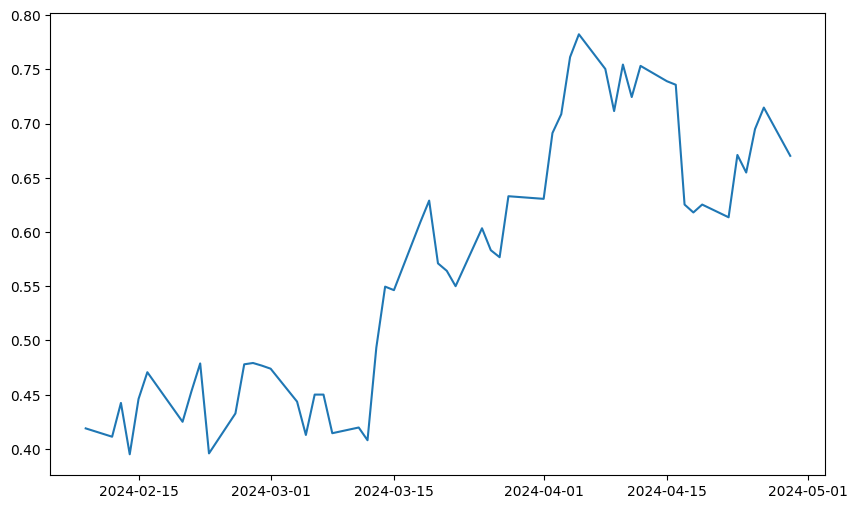

In [17]:
# Plot Prophet predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Price'], label='Actual Price')
plt.plot(test.index, prophet_pred, label='Prophet Predicted Price')
plt.title('Prophet Oil Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [18]:
# 6. Combine Predictions from All Models
lstm_pred = scaler.inverse_transform(lstm_pred)
transformer_pred = scaler.inverse_transform(transformer_pred)
# ensemble_pred = (lstm_pred + transformer_pred + prophet_pred.reshape(-1, 1)) / 3
ensemble_pred = (lstm_pred + transformer_pred ) / 2

Ensemble Mean Squared Error: 4.169594821373045


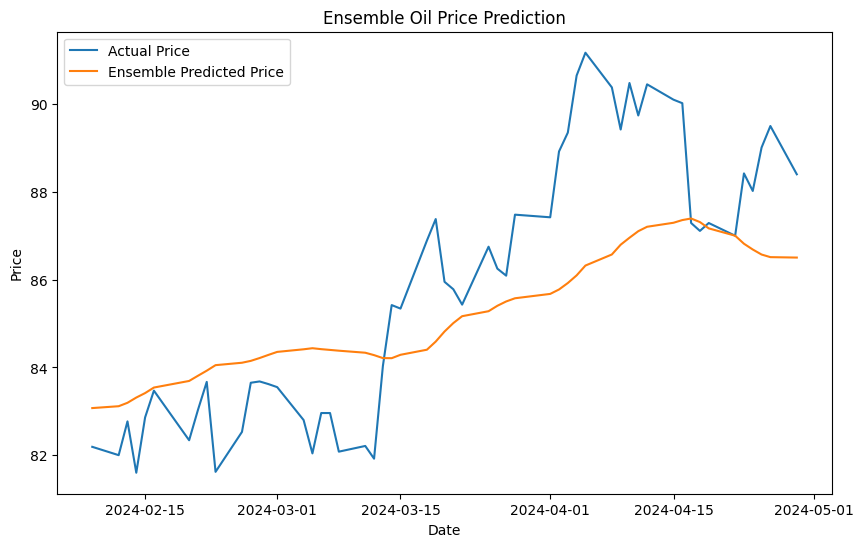

In [25]:
# 7. Evaluate the Ensemble Model
test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
ensemble_mse = mean_squared_error(test_actual, ensemble_pred)
print(f'Ensemble Mean Squared Error: {ensemble_mse}')

# Plot Ensemble predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test_actual, label='Actual Price')
plt.plot(test.index, ensemble_pred, label='Ensemble Predicted Price')
plt.title('Ensemble Oil Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig('outputs/Mean Ensemble Predicted Price')
plt.show()


Combined Mean Squared Error: 0.003123122189934016


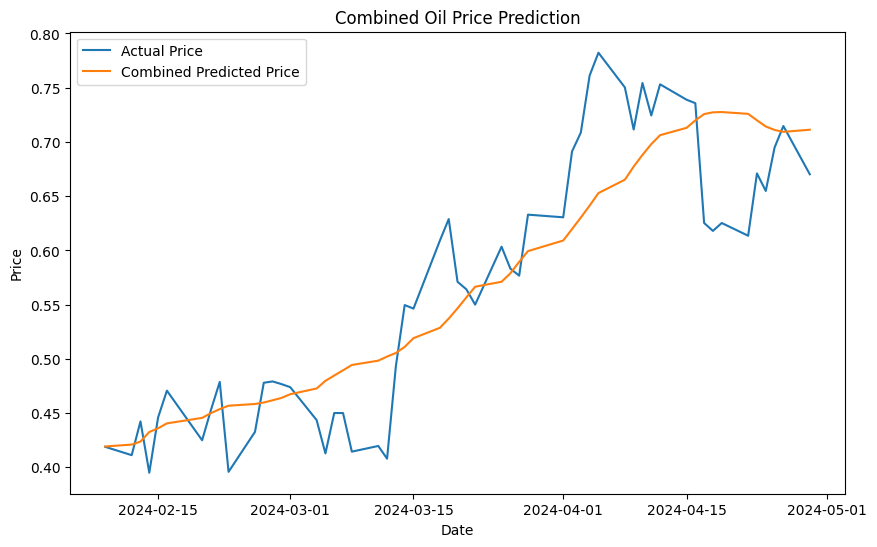

In [26]:
# 6. Train Linear Regression Model to Combine Predictions
# Inverse transform predictions to get them back to original scale
lstm_pred = scaler.inverse_transform(lstm_pred)
transformer_pred = scaler.inverse_transform(transformer_pred)
# prophet_pred = prophet_pred.reshape(-1, 1)

# Prepare training data for linear regression model
# train_combined = np.hstack((lstm_pred, transformer_pred, prophet_pred))
train_combined = np.hstack((lstm_pred, transformer_pred))

# Train the linear regression model
lr_model = LinearRegression()
lr_model.fit(train_combined, test['Price'])

# Make predictions with the linear regression model
combined_pred = lr_model.predict(train_combined)

# 7. Evaluate the Combined Model
test_actual = test['Price'].values.reshape(-1, 1)
combined_mse = mean_squared_error(test_actual, combined_pred)
print(f'Combined Mean Squared Error: {combined_mse}')

# Plot Combined predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test_actual, label='Actual Price')
plt.plot(test.index, combined_pred, label='Combined Predicted Price')
plt.title('Combined Oil Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig('outputs/Linear Regression Ensemble Predicted Price')
plt.show()

In [27]:
lr_model.coef_

array([ 3.1262960e-05, -3.1858562e-03], dtype=float32)